# Feature extraction

In [1]:
dataset_path='./dataset/Respiratory_dataset/'
demographic_info_file_name='demographic_info.txt'
patient_diagnosis_file_path=dataset_path + 'Respiratory_Sound_Database/'
patient_diagnosis_file_name='patient_diagnosis.csv'
audio_file_directory_path=dataset_path + 'Respiratory_Sound_Database/audio_and_txt_files/'
dataset_export_path='./dataset/Respiratory_dataset/respiratory-sound-database-export/export/'


audio_file_directory_path

'./dataset/Respiratory_dataset/Respiratory_Sound_Database/audio_and_txt_files/'

In [3]:
import findspark
findspark.init()
import pyspark

In [4]:
sc = pyspark.SparkContext(appName="RespiratoryDataAnalysis",
                         master="local[2]").getOrCreate()
sc

<SparkContext master=local[2] appName=RespiratoryDataAnalysis>

In [5]:
from pyspark import SQLContext
sql_c = SQLContext(sc)

In [6]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType
from pyspark.sql import DataFrame as df
from pyspark.sql import *

patient_diagnosis_schema = StructType([
    StructField("patientIdStr", StringType()),
    StructField("diagnosis", StringType())])

In [7]:
patient_diagnosis_df = sql_c.read.format("csv").schema(patient_diagnosis_schema).load(patient_diagnosis_file_path+patient_diagnosis_file_name)

In [8]:
patient_diagnosis_df = patient_diagnosis_df.withColumn("patientId", patient_diagnosis_df["patientIdStr"].cast("double"))

In [9]:
from pyspark.ml.feature import StringIndexer
df = patient_diagnosis_df.alias("df")

indexer = StringIndexer(inputCol="diagnosis", outputCol="diagnosisIndex")
patient_diagnosis_df = indexer.fit(patient_diagnosis_df).transform(patient_diagnosis_df)

In [10]:
patient_diagnosis_df.printSchema()

root
 |-- patientIdStr: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- patientId: double (nullable = true)
 |-- diagnosisIndex: double (nullable = false)



Now parsing audio file names and their annotation files
Filename format has 5 data:
Patient number (101,102,...,226)
Recording index
Chest location a. Trachea (Tc) b. Anterior left (Al) c. Anterior right (Ar) d. Posterior left (Pl) e. Posterior right (Pr) f. Lateral left (Ll) g. Lateral right (Lr)
Acquisition mode a. sequential/single channel (sc), b. simultaneous/multichannel (mc)
Recording equipment a. AKG C417L Microphone (AKGC417L), b. 3M Littmann Classic II SE Stethoscope (LittC2SE), c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200), d. WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)
The annotation text files have four columns:
Beginning of respiratory cycle(s)
End of respiratory cycle(s)
Presence/absence of crackles (presence=1, absence=0)
Presence/absence of wheezes (presence=1, absence=0)

The following libraries are used to process the dataset:
- glob: directories and files I/O
- soundfile: read .wav file; see https://pysoundfile.readthedocs.io/en/0.9.0/
- librosa: resample audio files; used for audio signals normalization; see https://librosa.github.io/librosa/
- pywt (pywavelets): high-level wavelet processing; see https://pywavelets.readthedocs.io/en/latest/#main-features
- numpy
- scikit-learn: ML

Note: TODO: enhance using sc.wholeTextFiles

In [11]:
import os
import io
import pywt
import matplotlib.pyplot as plt
import numpy as np
import glob
import librosa
import soundfile as sf

In [12]:
separator = '_'
audio_file_fields = []
audio_list =[]
for file_name in glob.iglob(audio_file_directory_path + '*.wav', recursive=False):
    file_name_base = os.path.basename(file_name)
    fileId = file_name_base.split('.')[0]
    file_field = fileId.split(separator)
    file_field.append(fileId)
    file_field.append(file_name_base)
    #reading audio file
    print('.', end='')
    data, sample_rate = librosa.load(file_name, mono='True')
    file_field.append(sample_rate)
    file_field.append(len(data))
    audio_list.append([file_name_base, file_field[0], file_field[1], sample_rate, data.tolist()])
    audio_file_fields.append(file_field)
audio_file_fields[:2]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[['122',
  '2b1',
  'Tc',
  'mc',
  'LittC2SE',
  '122_2b1_Tc_mc_LittC2SE',
  '122_2b1_Tc_mc_LittC2SE.wav',
  22050,
  441000],
 ['113',
  '1b1',
  'Lr',
  'sc',
  'Litt3200',
  '113_1b1_Lr_sc_Litt3200',
  '113_1b1_Lr_sc_Litt3200.wav',
  22050,
  321401]]

## Feature extraction from audio sample

Sound feature is constructed from audio_list (constructed as: [file_name_base, patientId, recordId, sample_data]) augmented with diagnosisIndex. The sample data is also refactored to be sampled at rate target_rate=12000 and split in smaller records of size target_length.

In [13]:
def resample_and_mfcc (sample, sample_rate, target_rate):
    # fonction to resample a time serie and return the corresponding mfcc
    from librosa import core as lcore
#    sample = librosa.to_mono(np.asarray(sample))
    resampled = lcore.resample(np.asarray(sample),\
                           orig_sr=sample_rate,\
                           target_sr=target_rate)
#    stft_out = librosa.amplitude_to_db(np.abs(librosa.stft(resampled)), ref=np.max)
    mfcc = librosa.feature.mfcc(y=resampled, sr=target_rate, n_mfcc=128)
    return mfcc

In [14]:
def split_sample(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

In [15]:
def extract_samples (sample_in, target_length, subsamples_nb=10):
    sample_out = []
    remaining_len = len(sample_in)
    parsed_len = 0
    while remaining_len >= target_length:
        sample_out.append(sample_in[parsed_len:parsed_len + target_length])
        remaining_len -= target_length
        parsed_len += target_length
        if len(sample_out) == subsamples_nb:
            remaining_len = 0
    if remaining_len > target_length / 2 :
        copy = np.zeros(target_length, dtype = np.float32)
        copy[:remaining_len] = sample_in[parsed_len:parsed_len+remaining_len]
        sample_out.append(np.asarray(copy))
    return sample_out

In [16]:
target_length = 60000 # approximately 4sec
target_rate = 12000

In [17]:
diag_index = patient_diagnosis_df.select('patientId', 'diagnosisIndex').orderBy('patientId').dropDuplicates().rdd.map(lambda x : (x.patientId, x.diagnosisIndex)).collect()

In [18]:
patient_diag_dict = {}
for index in range(len(diag_index)):
    patient_diag_dict[diag_index[index][0]] = diag_index[index][1]
    
patient_diag_dict[101.0]

2.0

In [19]:
mfcc_list = []
length = len(audio_list)
for audio_index in range(len(audio_list)):
    print('.', end='')
    if audio_index % 100 == 0:
        print(str(audio_index) + "/" + str(length), end='')
        
    sample = audio_list[audio_index][4]
    splitted_sample = extract_samples(sample, \
                                   target_length)
    for i in range(len(splitted_sample)):
        mfccs = resample_and_mfcc(splitted_sample[i], \
                                audio_list[audio_index][3], \
                                target_rate)
        patientId = float(audio_list[audio_index][1])
        diagnosisIndex = patient_diag_dict[patientId]


        mfcc_list.append([audio_list[audio_index][0], \
                        patientId, \
                        audio_list[audio_index][2], \
                        diagnosisIndex, \
                        mfccs.tolist()])

.0/920....................................................................................................100/920....................................................................................................200/920....................................................................................................300/920....................................................................................................400/920....................................................................................................500/920....................................................................................................600/920....................................................................................................700/920....................................................................................................800/920....................................................................................................900/920...................

In [20]:
len(mfcc_list)

6554

In [21]:
mfcc_list[0]

['122_2b1_Tc_mc_LittC2SE.wav',
 122.0,
 '2b1',
 5.0,
 [[-361.47699274697413,
   -382.3046592936434,
   -429.41395801328133,
   -448.8526299427671,
   -438.99888975818715,
   -433.96909115851406,
   -437.8589768774517,
   -427.2336843648852,
   -426.7204768555094,
   -431.3145433051428,
   -413.42159554768,
   -413.61165978520756,
   -424.20588356715723,
   -429.26396062611144,
   -435.13044189646183,
   -443.4282068495852,
   -457.7219786793497,
   -462.2956011292776,
   -434.8924989791676,
   -430.2605428483363,
   -448.2532150691795,
   -450.99691806632626,
   -447.01167028688025,
   -466.30042158012856,
   -470.84919727036316,
   -472.866833105782,
   -473.7010952448027,
   -472.0555783410294,
   -470.5750934168666,
   -461.85137705198,
   -447.531784686177,
   -438.1687974513784,
   -442.33179066725603,
   -435.56755382045435,
   -432.15132737216146,
   -435.70591111076914,
   -434.3928862821294,
   -434.1964721938142,
   -437.72126160594,
   -445.47443076400674,
   -448.2438432866

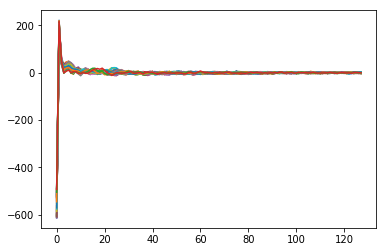

In [22]:
plt.plot(mfcc_list[100][4])
plt.show()

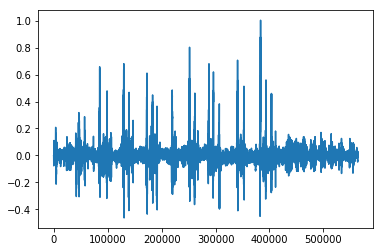

In [23]:
plt.plot(audio_list[100][4])
plt.show()

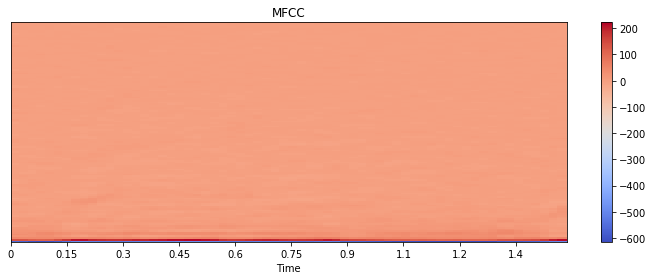

In [24]:
from librosa import display
plt.figure(figsize=(10, 4))
librosa.display.specshow(np.asarray(mfcc_list[100][4]), x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [25]:
data_df = sql_c.createDataFrame(mfcc_list)

In [26]:
data_df.show(1)

+--------------------+-----+---+---+--------------------+
|                  _1|   _2| _3| _4|                  _5|
+--------------------+-----+---+---+--------------------+
|122_2b1_Tc_mc_Lit...|122.0|2b1|5.0|[[-361.4769927469...|
+--------------------+-----+---+---+--------------------+
only showing top 1 row



In [27]:
from pyspark.sql import DataFrameWriter
data_df.coalesce(1).write.json(path=dataset_export_path+"respiratoryData_12kbps", mode = 'overwrite', compression='gzip')

In [28]:
## Test

In [29]:
mfcc_list = []
length = len(audio_list)
audio_index = 0
        
splitted_sample = extract_samples(audio_list[audio_index][4], \
                               target_length)
len(splitted_sample[0])


60000

In [30]:
import numpy as np
sample = np.array(splitted_sample[0])
stft_out = librosa.amplitude_to_db(np.abs(librosa.stft(sample)), ref=np.max)

In [36]:
len(stft_out)

1025

In [39]:
stft_out.shape

(1025, 118)

In [31]:
mfccs = resample_and_mfcc(audio_list[audio_index][4], \
                        audio_list[audio_index][3], \
                        target_rate)
patientId = float(audio_list[audio_index][1])
diagnosisIndex = patient_diag_dict[patientId]



In [40]:
mfccs.shape

(128, 469)

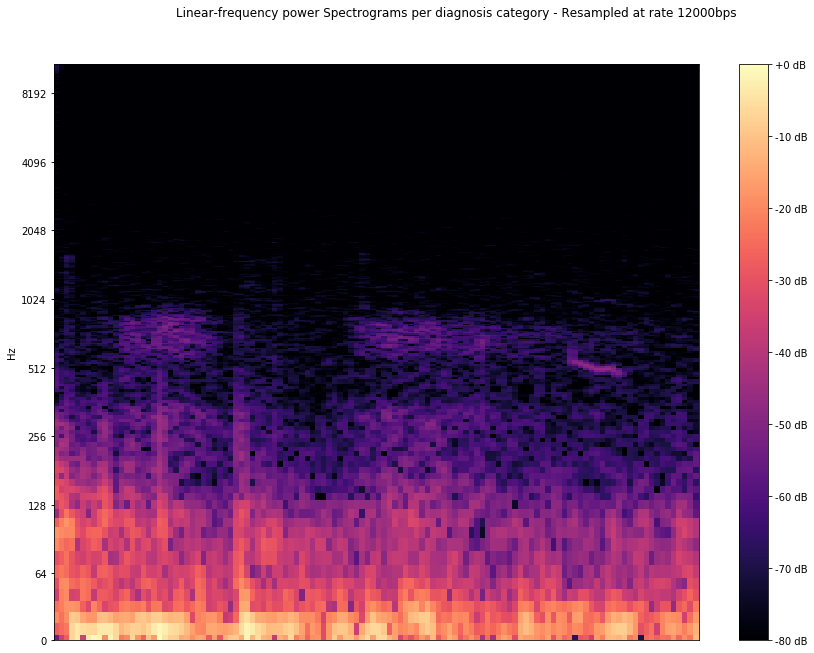

In [33]:
from librosa.display import *
fig = plt.figure(figsize=(14,10))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
fig.suptitle("Linear-frequency power Spectrograms per diagnosis category - Resampled at rate 12000bps")
librosa.display.specshow(stft_out, y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.show()

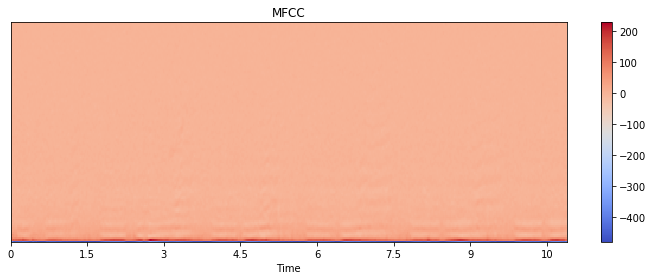

In [41]:
from librosa import display
plt.figure(figsize=(10, 4))
librosa.display.specshow(np.asarray(mfccs), x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [34]:
len(mfccs)

128

In [35]:

mfcc_list.append([audio_list[audio_index][0], \
                patientId, \
                audio_list[audio_index][2], \
                diagnosisIndex, \
                mfccs.tolist()])